## Set-up (for colab)
---

In [1]:
%%capture
!pip install pymc3==3.11

# PyShopper example
---
- This notebook contains a quick example of PyShopper that includes:
1. Loading data
2. Instantiating and fitting the Shopper model via MCMC sampling or variational inference
3. Inference diagnostics
4. Prediction on unseen test data

In [2]:
# Imports

import numpy as np
import pandas as pd
import filelock
import warnings

import theano

from pyshopper import shopper
from scipy import stats

from tqdm.notebook import tqdm

# Ignore FutureWarning and UserWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [3]:
import logging
logger = logging.getLogger('filelock')
logger.setLevel(logging.WARNING)

In [4]:
# URL to datasets
DATA_URL = 'https://github.com/topher-lo/PyShopper/blob/main/data'

## 1. Load data
---

In [5]:
# Load data
data = shopper.load_data(f'{DATA_URL}/train.tsv?raw=true', f'{DATA_URL}/prices.tsv?raw=true')
unique_items = sorted(data['item_id'].unique())
sessions_list = sorted(data['session_id'].unique())

# Limit data to C (most frequent) items and W sessions
# Note: we filter for trailing sessions because the tested dataset's sessions begin at the end of
# the training dataset's sessions
C = 2
W = 4

# Filter data
X_train = (data.loc[data['item_id'].isin(unique_items[:C])]
               .loc[data['session_id'].isin(sessions_list[-W:])]
               .reset_index(drop=True))

X_train

,user_id,item_id,session_id,quantity,price
0,1,100,397,1,1.0
1,2,100,397,1,1.0
2,3,100,397,1,1.0
3,5,100,397,1,1.0
4,6,100,397,1,1.0
...,...,...,...,...,...
405,91,100,398,1,5.0
406,94,100,398,1,5.0
407,96,100,398,1,5.0
408,104,100,398,1,5.0


## 2. Instantiate and fit model
---

In [6]:
# Create Shopper instance

model = shopper.Shopper(X_train)

INFO:root:Building the Shopper model...
INFO:root:Done building the Shopper model.


In [7]:
# # Fit model with MCMC sampling

# mcmc_res = model.fit(N=10000, method='MCMC')

In [8]:
# # Results summary:
# # Summary of common posterior statistics 
# # and sampling diagnostics

# mcmc_res.summary()

In [9]:
# Fit model with ADVI approximation

advi_res = model.fit(N=10, method='ADVI')

Finished [100%]: Average Loss = 34,986
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 34,986


In [10]:
# Results summary:
# Summary of common posterior statistics
# Note: must define number of draws from approximated posterior distribution

summary = advi_res.summary(draws=2)
summary

INFO:root:Sampling from posterior distribution...
INFO:root:Sampling complete.
INFO:root:Computing posterior statistics...


,mean,sd,hdi_3%,hdi_97%
"rho_c[0,0]",0.256,0.838,-0.336,0.848
"rho_c[0,1]",0.272,0.050,0.237,0.307
"rho_c[0,2]",-0.718,0.371,-0.980,-0.456
"rho_c[0,3]",0.589,1.051,-0.154,1.332
"rho_c[0,4]",0.695,0.287,0.492,0.898
...,...,...,...,...
"p[409,405]",0.003,0.001,0.003,0.004
"p[409,406]",0.003,0.001,0.003,0.004
"p[409,407]",0.003,0.001,0.003,0.004
"p[409,408]",0.003,0.001,0.003,0.004


## 3. Diagnostics
---

In [12]:
# # Sampling trace plot

# mcmc_res.trace_plot()

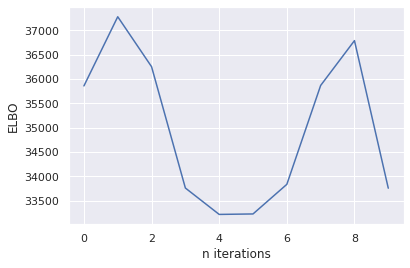

In [13]:
# ELBO plot (ADVI)

fig = advi_res.elbo_plot()

## 4. Prediction
---

In [14]:
# Load test data
test_data = shopper.load_data(f'{DATA_URL}/test.tsv?raw=true',
                              f'{DATA_URL}/prices.tsv?raw=true')
test_sessions_list = sorted(test_data['session_id'].unique())

W_test = int(0.33*W)

# Limit data to C items and U users
X_test = (test_data.loc[test_data['item_id'].isin(unique_items[:C])]
                   .loc[test_data['session_id'].isin(test_sessions_list[-W_test:])]
                   .reset_index(drop=True))

X_test

,user_id,item_id,session_id,quantity,price
0,11,101,430,1,5.0
1,33,101,430,1,5.0
2,35,101,430,1,5.0
3,38,101,430,1,5.0
4,59,101,430,1,5.0
5,61,101,430,1,5.0
6,68,101,430,1,5.0
7,73,101,430,1,5.0
8,94,101,430,1,5.0
9,102,101,430,1,5.0


In [15]:
# ADVI Predictions

preds = advi_res.predict(X_test, draws=100)

INFO:root:Sampling from posterior distribution...
INFO:root:Sampling complete.
